# DDM goodness of fit and parameters

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon, pearsonr, spearmanr
from statsmodels.stats.weightstats import DescrStatsW

from dynamic_bias import utils
utils.setup_matplotlib()

In [2]:
behavior = utils.load_behavior()
id_list = np.unique(behavior.ID)

from dynamic_bias.models.ddm import model
sys.modules['model'] = model

utils.download_dataset("models/ddm")
model_path = f'{utils.ORIGIN}/models/ddm/'

# Full (drift-diffusion) model
models = {}
for v_id in id_list:
    fn_id = f'{v_id:04d}'
    fn = f'fitted_model_sub-{fn_id}.pkl'
    _model = utils.load(model_path+'full/'+fn)
    models[fn_id] = _model
    
name_par = ['w_K', 'w_E', 'w_P', 'w_D', 'w_r', 'w_a', 'lambda', 's']
name_par_latex = [r'$w_K$', r'$w_E$', r'$w_P$', r'$w_D$', r'$w_\rho$', r'$w_\alpha$', r'$w_\lambda$', r'$s$']

fit_par_value_full = {}
for i,n in enumerate(name_par):
    fit_par_value_full[n] = np.nan*np.zeros(50)
    for i_sub, (k,v) in enumerate(models.items()):
        fit_par_value_full[n][i_sub] = v.fitted_params[i]
        
lkds_full = np.array([v.loglik for _,v in models.items()])
ns  = np.array([v.mask_cw.shape[-1] for _,v in models.items()])
ll  = lkds_full - np.log(_model.dm*90/np.pi)*ns
bic_full = len(_model.fitted_params) * np.log(ns) - 2*ll

# Reduced (diffusion-only) model
models = {}
for v_id in id_list:
    fn_id = f'{v_id:04d}'
    fn = f'fitted_model_sub-{fn_id}.pkl'
    _model = utils.load(model_path+'reduced/'+fn)
    models[fn_id] = _model

fit_par_value_reduced = {}
for i,n in enumerate(name_par[1:]):
    fit_par_value_reduced[n] = np.nan*np.zeros(50)
    for i_sub, (k,v) in enumerate(models.items()):
        fit_par_value_reduced[n][i_sub] = v.fitted_params[i]
        
lkds_reduced = np.array([v.loglik for _,v in models.items()])
ns  = np.array([v.mask_cw.shape[-1] for _,v in models.items()])
ll  = lkds_reduced - np.log(_model.dm*90/np.pi)*ns
bic_reduced = len(_model.fitted_params) * np.log(ns) - 2*ll

downloading data/processed/behavior...
data/processed/behavior already exists. Skipping download...
downloading models/ddm...
models/ddm already exists. Skipping download...


In [3]:
x_params = {}
x_params['w_K'] = {'label': 'Drift\nrate' + r'$(\!\!^\circ\!\!/s)$', 
                   'xlims': [0, 5],  'xticks': [0,2.5,5],   'xticklabels': ['0','2.5','5']}
x_params['w_E'] = {'label': 'Encoding\nvariability' + r'$(\!\!^\circ\!\!)$', 
                   'xlims': [0,10],  'xticks': [0,5,10],    'xticklabels': ['0','5','10']}
x_params['w_P'] = {'label': 'Production\nvariability' + r'$(\!\!^\circ\!\!)$', 
                   'xlims': [0,15],  'xticks': [0,5,10,15], 'xticklabels': ['0','5','10','15']}
x_params['w_D'] = {'label': 'Diffusion\nrate' + r'$(\!\!^\circ\!\!/\sqrt{s})$', 
                   'xlims': [0,5],   'xticks': [0,2.5,5],   'xticklabels': ['0','2.5','5']}
x_params['w_r'] = {'label': 'Reference\nbias', 
                   'xlims': [0,0.4], 'xticks': [0,0.2,0.4], 'xticklabels': ['0','0.2','0.4']}
x_params['w_a'] = {'label': 'Choice\ninduced bias', 
                   'xlims': [-8,8],  'xticks': [-4,0,4],    'xticklabels': ['-4','0','4']}
x_params['lambda'] = {'label': 'Choice\nlapse rate', 
                      'xlims': [0,0.15], 'xticks': [0,0.1], 'xticklabels': ['0','0.1']}
x_params['s'] = {'label': 'Encoding\nshape', 
                 'xlims': [0,1], 'xticks': [0,0.5,1],   'xticklabels': ['0','0.5','1']}

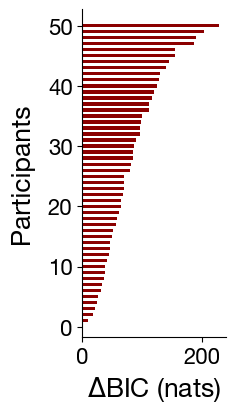

In [4]:
argsort = np.argsort(bic_reduced-bic_full)

plt.figure(figsize=[2.2,4])
plt.barh(np.arange(1,51), (bic_reduced-bic_full)[argsort], align='center', color='darkred', height=0.55)
plt.tight_layout()

plt.xlabel(r'$\Delta$BIC (nats)')
plt.ylabel('Participants', labelpad=10)
plt.savefig(f'{utils.DIR_FIGURE}/figs2a.pdf',bbox_inches='tight',transparent=True)
plt.show()

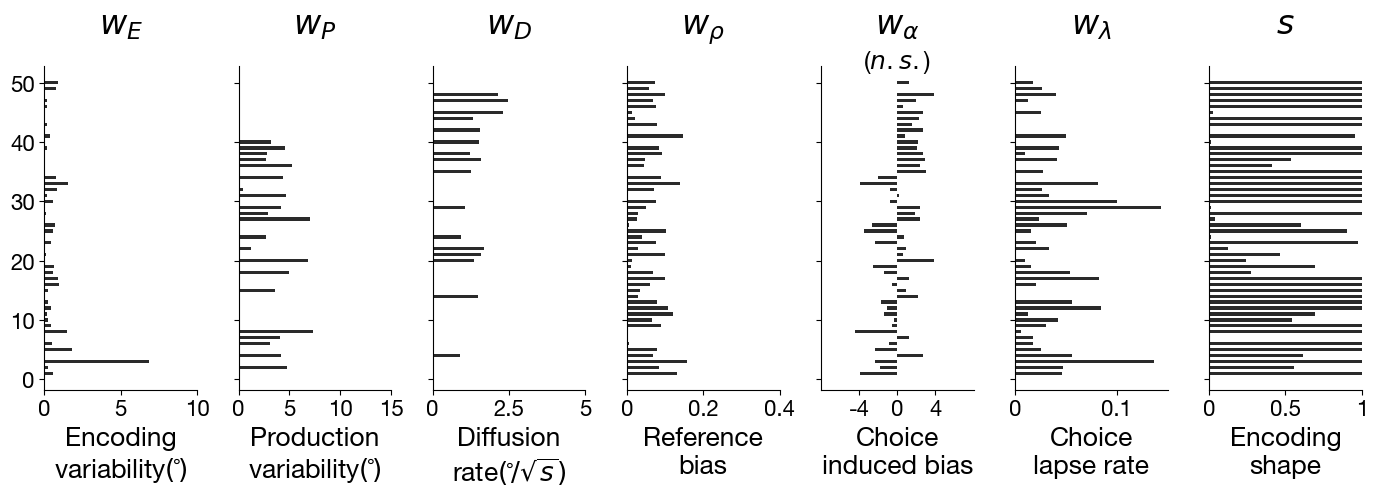

In [5]:
# plot the fitted parameters of the reduced model
f,ax = plt.subplots(1,7,figsize=[14,5.2],sharey=True)
for i,(k,v) in enumerate(fit_par_value_reduced.items()):
    ax[i].set_title(name_par_latex[i+1])
    ax[i].barh(np.arange(1,51), v[argsort], align='center', color='#2a2a2a', height=0.55)
    ax[i].set_xlim(x_params[k]['xlims'])
    ax[i].set_xticks(x_params[k]['xticks'])
    ax[i].set_xticklabels(x_params[k]['xticklabels'])
    ax[i].set_xlabel(x_params[k]['label'])

    if k == 'w_a':
        ax[i].text(0,52.5, r'($n.s.$)', fontsize=18, ha='center')

plt.tight_layout()
plt.savefig(f'{utils.DIR_FIGURE}/figs2b.pdf',bbox_inches='tight',transparent=True)
plt.show()

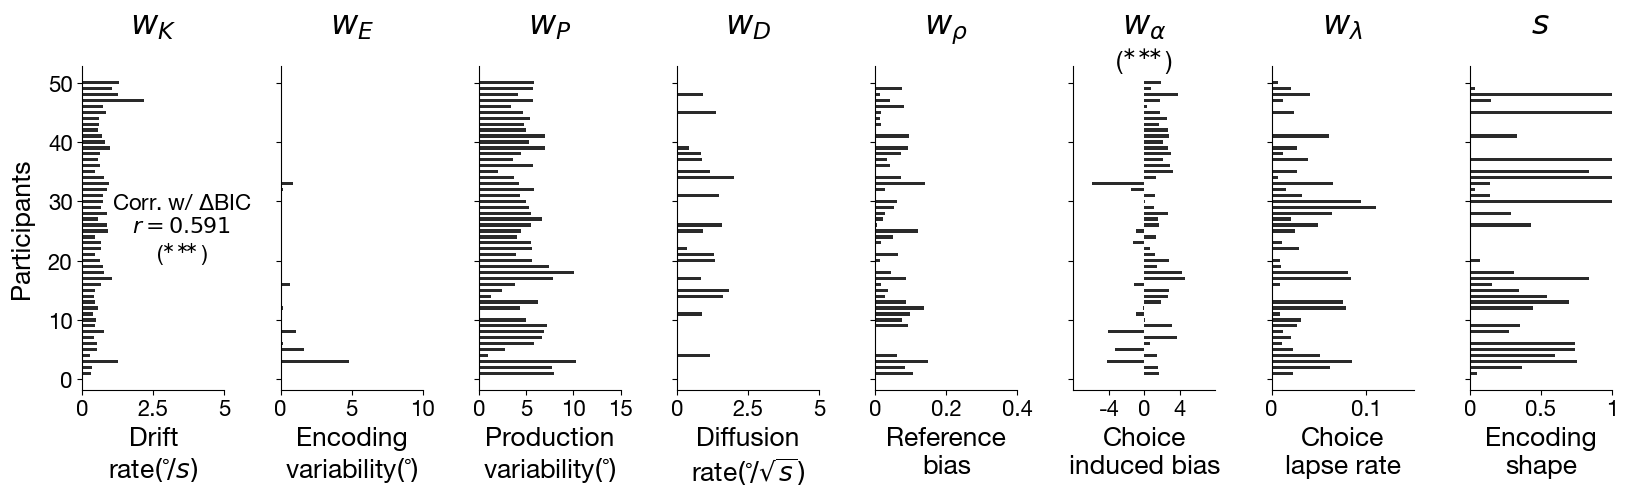

In [6]:
# plot the fitted parameters of the full model
f,ax = plt.subplots(1,8,figsize=[16.5,5.2],sharey=True)
for i,(k,v) in enumerate(fit_par_value_full.items()):
    ax[i].set_title(name_par_latex[i])
    ax[i].barh(np.arange(1,51), v[argsort], align='center', color='#2a2a2a', height=0.55)
    ax[i].set_xlim(x_params[k]['xlims'])
    ax[i].set_xticks(x_params[k]['xticks'])
    ax[i].set_xticklabels(x_params[k]['xticklabels'])
    ax[i].set_xlabel(x_params[k]['label'])

    if k == 'w_K':
        ax[i].text(3.5,20, 'Corr. w/ ' + r'$\Delta$BIC' + '\n' + 
                   r'$r=0.591$' + '\n' + r'($  ^{\ast\!\ast\!\!\!\!\ast}$)', fontsize=16, ha='center')
        ax[i].set_ylabel('Participants', labelpad=10)

    if k == 'w_a':
        ax[i].text(0,52.5, r'($  ^{\ast\!\ast\!\!\!\!\ast}$)', fontsize=18, ha='center')

plt.tight_layout()
plt.savefig(f'{utils.DIR_FIGURE}/figs2c.pdf',bbox_inches='tight',transparent=True)
plt.show()

In [7]:
ttest  = DescrStatsW(fit_par_value_reduced['w_a'])
wilcox = wilcoxon(fit_par_value_reduced['w_a'])
print("Reduced (Diffusion-only) model, w_alpha versus 0")
print('Paired samples t-test')
print('t(49)=',  ttest.ttest_mean()[0], 'p=', ttest.ttest_mean()[1])
print('95% CI=', ttest.tconfint_mean())
print('Wilcoxon signed-rank test (without continuity correction)')
print('V=', wilcox[0], 'p=', wilcox[1])

ttest  = DescrStatsW(fit_par_value_full['w_a'])
wilcox = wilcoxon(fit_par_value_full['w_a'])
print("\nFull (Drift-diffusion) model, w_alpha versus 0")
print('Paired samples t-test')
print('t(49)=',  ttest.ttest_mean()[0], 'p=', ttest.ttest_mean()[1])
print('95% CI=', ttest.tconfint_mean())
print('Wilcoxon signed-rank test (without continuity correction)')
print('V=', wilcox[0], 'p=', wilcox[1])

spear = spearmanr(fit_par_value_full['w_K'], (bic_reduced-bic_full))
pears = pearsonr(fit_par_value_full['w_K'], (bic_reduced-bic_full))
pears_CI = utils.pearson_CI(fit_par_value_full['w_K'], (bic_reduced-bic_full))
print("\nCorrelation between w_K and likelihood gain")
print('Pearson r=', pears[0], 'p=', pears[1])
print('Pearson CI=', pears_CI)
print('Spearman rho=', spear.correlation, 'p=', spear.pvalue)


spear = spearmanr(fit_par_value_full['w_a'], (bic_reduced-bic_full))
pears = pearsonr(fit_par_value_full['w_a'], (bic_reduced-bic_full))
pears_CI = utils.pearson_CI(fit_par_value_full['w_a'], (bic_reduced-bic_full))
print("\nCorrelation between w_alpha and likelihood gain")
print('Pearson r=', pears[0], 'p=', pears[1])
print('Pearson CI=', pears_CI)
print('Spearman rho=', spear.correlation, 'p=', spear.pvalue)

Reduced (Diffusion-only) model, w_alpha versus 0
Paired samples t-test
t(49)= 0.851978595000456 p= 0.3983709368740709
95% CI= (-0.3593424686854386, 0.8882868024040057)
Wilcoxon signed-rank test (without continuity correction)
V= 532.0 p= 0.31366564109611517

Full (Drift-diffusion) model, w_alpha versus 0
Paired samples t-test
t(49)= 3.7145242545905277 p= 0.0005218411011125934
95% CI= (0.5235862930226493, 1.7578590310002324)
Wilcoxon signed-rank test (without continuity correction)
V= 251.0 p= 0.00010867611974241242

Correlation between w_K and likelihood gain
Pearson r= 0.5907724305124925 p= 6.286795794936572e-06
Pearson CI= (0.3739106361453757, 0.7463845547739433)
Spearman rho= 0.5411284513805522 p= 4.960274535232223e-05

Correlation between w_alpha and likelihood gain
Pearson r= 0.24251962049978484 p= 0.08970884533582851
Pearson CI= (-0.038421749922212346, 0.4879297472869886)
Spearman rho= 0.2467707082833133 p= 0.08405493531897798
